In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tensorboardX import SummaryWriter

import numpy as np

from tqdm import tqdm
from tqdm import trange

# import math
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
        
        
def output_final(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_loss_inf = 0, 0


    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            test_loss_inf += torch.linalg.vector_norm(pred-y, ord = float('inf')).item()
    test_loss /= num_batches
    test_loss_inf /= num_batches


    return test_loss, test_loss_inf


In [ ]:
num_sample = 2000*32
num_train = int(num_sample*0.8)
num_test = int(num_sample*0.2)

adjust_scale = 0

loss_fn = nn.MSELoss()

width_vector = [5, 10, 20, 40, 80, 160]

width_vector_2 = width_vector


times_w = 26

times_n = 32

merge = 0.75

k_period = 20

batch_size = 640

parall_size = 10


result_matrix = np.zeros((len(width_vector), parall_size))
result_matrix_infty = np.zeros((len(width_vector), parall_size))

result_matrix_adj = np.zeros((len(width_vector_2), parall_size))
result_matrix_infty_adj = np.zeros((len(width_vector_2), parall_size))

In [ ]:
#generate test set
temp = torch.linspace(-1, 1, int(np.sqrt(num_test)))
x_1, x_2, x_3 = torch.meshgrid(temp, temp, temp)


                      
# for consistency of tensor sizes
X_1 = torch.unsqueeze(x_1.reshape(-1),1)
X_2 = torch.unsqueeze(x_2.reshape(-1),1)
X_3 = torch.unsqueeze(x_3.reshape(-1),1)

x_test = torch.cat([X_1, X_2, X_3], dim=1)


# certain function expression: y = sin(2 \pi x)
y_test = torch.unsqueeze(torch.sin(3 * x_test[:, 0]) * torch.cos(1 * x_test[:, 1]) * torch.sin(2 * x_test[:, 2]), 1)

# create data loaders.
test_set = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_set, batch_size = num_test, shuffle=False)

y_test_plot = - torch.sin(torch.pi * x_1 * x_2)

/home/22040517r/anaconda3/envs/torch/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
i = 0

# for times_n in tqdm(para_vector):
for width in tqdm(width_vector):
    
    actual_width = times_w*(2*width+1)

    class NN(nn.Module):
        def __init__(self, layers=[3, actual_width, 1, 1]):
            # First initial the __init__ in nn.Module 
            super(NN, self).__init__()
            
            self.layer1 = nn.Linear(in_features=layers[0], out_features=layers[1])
            self.relu = nn.ReLU()
            self.layer2 = nn.Linear(in_features=layers[1], out_features=layers[2], bias=False)
            self.layer3 = nn.Linear(in_features=layers[2], out_features=layers[3], bias=True)



        def forward(self, x):
            unacti = self.layer1(x)
            hidden1 = self.relu(unacti)
            hidden2 = self.layer2(hidden1)
            logits = self.layer3(hidden2)

            return logits
        
        
        
    for j in range(parall_size):

        model = NN().to(device)
        
        adjust_scale = 0

        model.load_state_dict(torch.load('weight-random-sqrt-k'+str(k_period)+'-W'+str(width)+'-adj'+str(adjust_scale)+'.pth'))
        
        [result_matrix[i, j], result_matrix_infty[i, j]] = output_final(test_dataloader, model, loss_fn)
        

        
    i += 1    
        
  

100%|██████████| 6/6 [09:44<00:00, 97.37s/it]


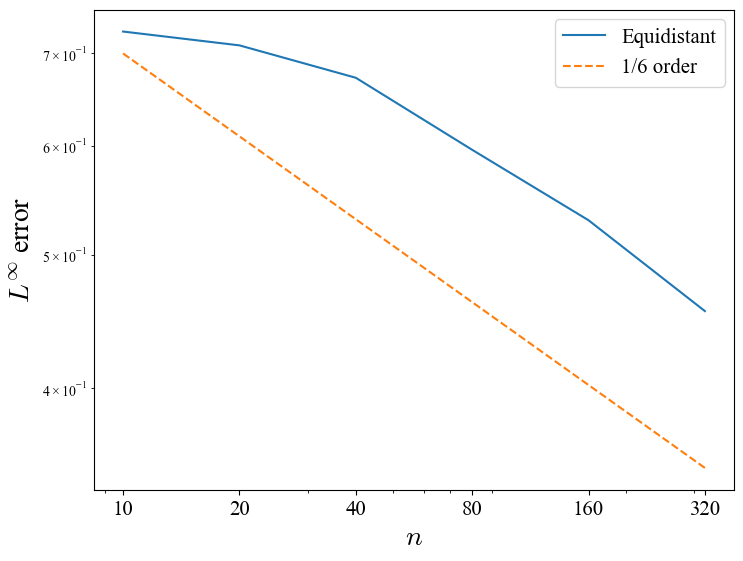

In [ ]:
from statistics import geometric_mean


import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'


x = np.dot(width_vector, 2)


mean = np.zeros(int(len(x)))
mean_inf = np.zeros(int(len(x)))


for i in range(len(x)):
    mean[i] = geometric_mean(result_matrix[i])
    mean_inf[i] = geometric_mean(result_matrix_infty[i])


y_max = np.max(result_matrix, axis = 1)
y_min = np.min(result_matrix, axis = 1)

yerr = np.abs(np.vstack((y_min, y_max)) - mean)

y_max_inf = np.max(result_matrix_infty, axis = 1)
y_min_inf = np.min(result_matrix_infty, axis = 1)

yerr_inf = np.abs(np.vstack((y_min_inf, y_max_inf)) - mean_inf)






# for reference





fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])


plt.plot(x, mean_inf, label='Equidistant')


begin_point = 7E-1

x_ref = [x[0], x[-1]]
y_ref = [begin_point, begin_point/np.power(np.power(2,len(x)), 1/6)]

plt.plot(x_ref, y_ref, linestyle='--', label='1/6 order')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$', size=20)
plt.ylabel('$L^\infty$ error', size=20)
plt.legend(fontsize=15, loc=(0.72, 0.84))
plt.xticks(x, x, fontsize=15)
plt.yticks(fontsize=15)



plt.savefig('plot.pdf', bbox_inches='tight')
plt.show()